In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import tensorflow.keras.utils as utils
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [64]:
jobseeker = pd.read_csv('/content/jobseeker.csv')
jobseeker.head(5)

,id,nama,alamat,pendidikan,pengalaman,pengalaman_tahun,keterampilan,peminatan
0,1,Devi Laksita,KABUPATEN BATU BARA,SMP,Retail dan Dagang,3,Inovasi,Pariwisata
1,2,Maryadi Damanik,KABUPATEN ACEH TIMUR,SD,Freelance,3,Komunikasi,Pekerjaan Lepas
2,3,Harsana Puspasari,KABUPATEN BANTUL,SMP,Teknologi,3,Pemasaran,Tidak Ada Pengalaman
3,4,Banawi Pratiwi,KABUPATEN ENREKANG,SMP,Retail dan Dagang,3,Teknologi Informasi,Teknik
4,5,Karen Waskita,KABUPATEN PUNCAK,S1/D4,Pekerjaan Lepas,2,Adaptasi,Teknik


In [65]:
#menghapus spasi di depan kolom
jobseeker.columns = jobseeker.columns.str.strip()

In [66]:
# Fungsi untuk menentukan nilai label berdasarkan peminatan dan keterampilan
def assign_label(row):
    if row['peminatan'] in ['Freelance', 'Pariwisata', 'Retail dan Dagang', 'Teknologi'] and row['keterampilan'] in ['Mengembangkan Jaringan', 'Pemasaran', 'Penjualan', 'Kepemimpinan', 'Pemasaran']:
        return 'Pelayanan'
    elif row['peminatan'] in ['Pariwisata', 'Freelance', 'Teknik'] and row['keterampilan'] in ['Inovasi', 'Komunikasi', 'Adaptasi', 'Kepemimpinan']:
        return 'Pariwisata'
    elif row['peminatan'] in ['Teknik', 'Teknologi', 'Retail dan Dagang', 'Teknologi'] and row['keterampilan'] in ['Adaptasi', 'Komunikasi', 'Pemasaran']:
        return 'Pekerja Lepas'
    elif row['peminatan'] in ['Teknologi', 'Teknik', 'Freelance'] and row['keterampilan'] in ['Mengembangkan Jaringan', 'Manajemen', 'Teknologi Informasi']:
        return 'Teknik'
    elif row['peminatan'] in ['Pekerjaan Lepas', 'Pelayanan'] and row['keterampilan'] in ['Adaptasi', 'Manajemen']:
        return 'Freelance'
    elif row['peminatan'] == ['Tidak Ada Pengalaman', 'Pariwisata', ] and row['keterampilan'] in ['Adaptasi', 'Komunikasi',]:
        return 'Pariwisata'
    elif row['peminatan'] in ['Pekerja Lepas', 'Tidak Ada Pengalaman', 'Freelance'] and row['keterampilan'] in ['Keuangan', 'Manajemen', 'Adaptasi', 'Pemasaran']:
        return 'Retail dan Dagang'
    else:
        return 'Teknologi'

# Tambahkan kolom label berdasarkan kriteria
jobseeker['label'] = jobseeker.apply(assign_label, axis=1)

# Tampilkan dataset dengan kolom label baru
print(jobseeker)


       id                 nama                    alamat pendidikan  \
0       1         Devi Laksita       KABUPATEN BATU BARA        SMP   
1       2      Maryadi Damanik      KABUPATEN ACEH TIMUR         SD   
2       3    Harsana Puspasari          KABUPATEN BANTUL        SMP   
3       4       Banawi Pratiwi        KABUPATEN ENREKANG        SMP   
4       5        Karen Waskita          KABUPATEN PUNCAK      S1/D4   
..    ...                  ...                       ...        ...   
995   996     Among Laksmiwati       KABUPATEN MANOKWARI         SD   
996   997       Galih Dongoran    KABUPATEN SUMBA TENGAH    SMA/SMK   
997   998  Bakianto Zulkarnain  KABUPATEN SORONG SELATAN        SMP   
998   999     Jaswadi Lazuardi    KABUPATEN LOMBOK BARAT        SMP   
999  1000     Nabila Oktaviani     KABUPATEN KULON PROGO         SD   

            pengalaman  pengalaman_tahun            keterampilan  \
0    Retail dan Dagang                 3                 Inovasi   
1          

In [67]:
# Memisahkan fitur (X) dan label (y)
X = jobseeker[['peminatan', 'keterampilan']]
y = jobseeker['label']

# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Menggunakan LabelEncoder untuk mengonversi kolom target menjadi nilai numerik
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Menggunakan One-Hot Encoding untuk mengonversi fitur kategorikal
column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1])], remainder='passthrough')
X_train_encoded = column_transformer.fit_transform(X_train)

# Membuat instance Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Melatih model dengan data yang telah diencode
dt_classifier.fit(X_train_encoded, y_train_encoded)

DecisionTreeClassifier()

In [75]:
# Mengonversi label pada data test menggunakan LabelEncoder
y_test_encoded = label_encoder.transform(y_test)

# Mengonversi fitur pada data test menggunakan ColumnTransformer
X_test_encoded = column_transformer.transform(X_test)

# Definisikan model klasifikasi menggunakan TensorFlow
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_encoded.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model dengan data yang telah diencode
model.fit(X_train_encoded, y_train_encoded, epochs=10, batch_size=32)

# Evaluasi model pada data uji yang telah diencode
_, accuracy = model.evaluate(X_test_encoded, y_test_encoded)

# Print akurasi model
print("Akurasi model:", accuracy)

Epoch 1/10
25/25 [==============================] - 2s 3ms/step - loss: 1.7997 - accuracy: 0.4025
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.4469 - accuracy: 0.4737
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.2121 - accuracy: 0.4950
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 0.9834 - accuracy: 0.6525
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.7424 - accuracy: 0.7775
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.5140 - accuracy: 0.8562
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 0.3395 - accuracy: 0.9538
Epoch 8/10
25/25 [==============================] - 0s 4ms/step - loss: 0.2209 - accuracy: 0.9912
Epoch 9/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1469 - accuracy: 0.9950
Epoch 10/10
7/7 [==============================] - 0s 8ms/step - loss: 0.1168 - accuracy: 0.9900
Akurasi model: 0.9900

In [84]:
# Melakukan prediksi pada data pelatihan
y_train_pred = dt_classifier.predict(X_train_encoded)

# Menghitung confusion matrix
cm = confusion_matrix(y_train_encoded, y_train_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 31   0   0   0   0   0   0]
 [  0  94   0   0   0   0   0]
 [  0   0  40   0   0   0   0]
 [  0   0   0 142   0   0   0]
 [  0   0   0   0  44   0   0]
 [  0   0   0   0   0  70   0]
 [  0   0   0   0   0   0 379]]


In [86]:
# Membuat prediksi pada data uji
y_pred = model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)

print("Confusion Matrix:")
print(cm)

7/7 [==============================] - 0s 3ms/step
Confusion Matrix:
[[15  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0]
 [ 0  0 10  0  0  0  0]
 [ 0  0  0 36  0  0  0]
 [ 0  0  0  0  8  0  0]
 [ 0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0 90]]


In [87]:
# Test
test = jobseeker.loc[(jobseeker['keterampilan'] == 'Komunikasi') & (jobseeker['peminatan'] == 'Pekerjaan Lepas'), 'label'].values[0]

# Menampilkan output
print(test)


Teknologi


**EVALUASI**

In [88]:
# Melakukan prediksi menggunakan model pada data uji
y_pred = model.predict(X_test_encoded)

# Mengonversi prediksi menjadi label kategori
y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

# Mengonversi label kategori asli pada data uji
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Menampilkan hasil evaluasi
print("Akurasi:", accuracy)
print("Presisi:", precision)
print("Recall:", recall)
print("F1-score:", f1)

7/7 [==============================] - 0s 2ms/step
Akurasi: 1.0
Presisi: 1.0
Recall: 1.0
F1-score: 1.0


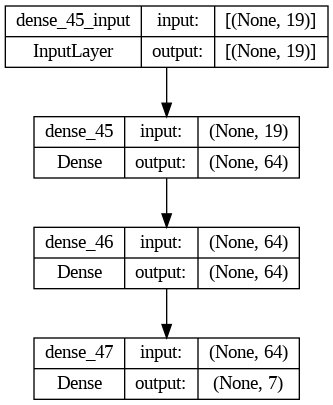

In [89]:
# Visualisasi arsitektur model Sequential
utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)

Epoch 1/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 8/10
25/25 [==

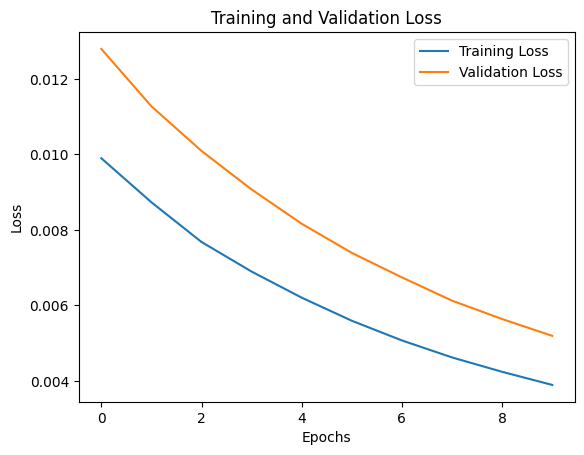

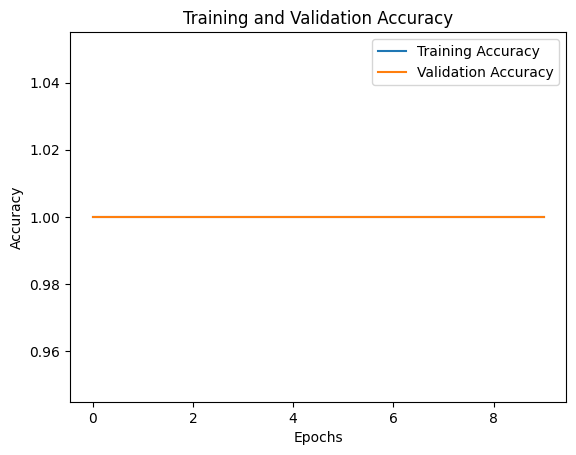

In [90]:
# Membuat instance dari History callback
history = model.fit(X_train_encoded, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test_encoded, y_test_encoded), callbacks=[tf.keras.callbacks.History()])

# Menampilkan Training and Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

# Menampilkan Training and Validation Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()


**MENYIMPAN FILE DALAM H5**

In [93]:
# Simpan model dalam format .h5
model.save('model.h5')